In [5]:
!nvidia-smi


Sat Jan 21 16:10:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download the dataset

In [6]:
!pip -q install --upgrade --no-cache-dir gdown

In [7]:
!gdown 1UO8sV72QpdvCQQ9belgwUEXauI16QDHl


Downloading...
From: https://drive.google.com/uc?id=1UO8sV72QpdvCQQ9belgwUEXauI16QDHl
To: /kaggle/working/dataset_img_v5.zip
100%|███████████████████████████████████████| 2.07G/2.07G [00:11<00:00, 176MB/s]


In [8]:
!unzip -qq dataset_img_v5.zip
!mv dataset_img_v5/ dataset/

# Importing

In [9]:
import torch
import torch.nn as nn
import torchvision as tv
import torch.optim as optim
from skimage.io import imread_collection
from torch.utils.data import DataLoader, random_split, Dataset
import pandas as pd
import ast
import json
import os
import numpy as np

import itertools

from PIL import Image

import cv2
from matplotlib import pyplot as plt

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Preprocessing

In [12]:
root = '/kaggle/working/dataset'
sequence_dir_list = sorted(os.listdir(root + '/sequences/'))

df = pd.DataFrame()
ground_truth=[]
sequence_num=[]
bird_eye_view_full_path = []
height_img360_full_path = []
img360_full_path = []
intensity_img360_full_path = []
range_img360_full_path = []

poses_file_list = sorted(os.listdir(root + '/poses/'))
for fname in poses_file_list:
  poses = np.loadtxt(root + '/poses/' + fname)
  poses = poses.reshape(-1, 3, 4)
  gt=[]
  prev_pose= [0]*6
  for pose in poses:
    decomposed = cv2.decomposeProjectionMatrix(pose)
    transVect, eulerAngles = decomposed[2], decomposed[-1]
    transVect = transVect/transVect[3]
    curr_pose = np.concatenate((transVect[:-1],eulerAngles)).ravel()
    # print(np.round(prev_pose[3:]),np.round(curr_pose[3:]))
    for i in range(3,6):

      if curr_pose[i] < prev_pose[i] - 180: curr_pose[i] = 360 + curr_pose[i] 
      if curr_pose[i] > prev_pose[i] + 180: curr_pose[i] = -360 + curr_pose[i]
    prev_pose = curr_pose
    gt.append(prev_pose)
  ground_truth.append(gt)
ground_truth= list(itertools.chain(*ground_truth))





for seq_dir in sequence_dir_list:
  seq_path = root + '/sequences/' + seq_dir 
  bird_eye_view_file_list = sorted(os.listdir(seq_path+ '/bird_eye_view/'))
  bird_eye_view_file_list = [ seq_path+ '/bird_eye_view/' + s for s in bird_eye_view_file_list]
  height_img360_file_list = sorted(os.listdir(seq_path+'/height_img360/'))
  height_img360_file_list = [ seq_path+'/height_img360/' + s for s in height_img360_file_list]
  img360_file_list = sorted(os.listdir(seq_path+ '/img360/'))
  img360_file_list = [ seq_path+ '/img360/' + s for s in img360_file_list]
  intensity_img360_file_list = sorted(os.listdir(seq_path+'/intensity_img360/'))
  intensity_img360_file_list = [ seq_path+'/intensity_img360/' + s for s in intensity_img360_file_list]
  range_img360_file_list = sorted(os.listdir(seq_path+'/range_img360/'))
  range_img360_file_list = [ seq_path+'/range_img360/' + s for s in range_img360_file_list]
  seq_num = [seq_dir]*len(img360_file_list)
  sequence_num.append(seq_num)
  bird_eye_view_full_path.append(bird_eye_view_file_list)
  height_img360_full_path.append(height_img360_file_list)
  img360_full_path.append(img360_file_list)
  intensity_img360_full_path.append(intensity_img360_file_list)
  range_img360_full_path.append(range_img360_file_list)

sequence_num= list(itertools.chain(*sequence_num))
bird_eye_view_full_path =  list(itertools.chain(*bird_eye_view_full_path))
height_img360_full_path =  list(itertools.chain(*height_img360_full_path))
img360_full_path =  list(itertools.chain(*img360_full_path))
intensity_img360_full_path =  list(itertools.chain(*intensity_img360_full_path))
range_img360_full_path =  list(itertools.chain(*range_img360_full_path))


df['seq_num'] = sequence_num
df['ground_truth'] = ground_truth
df['bird_eye_view'] = bird_eye_view_full_path
df['height'] = height_img360_full_path
df['img360'] = img360_full_path
df['intensity'] = intensity_img360_full_path
df['range'] = range_img360_full_path


df.head()


,seq_num,ground_truth,bird_eye_view,height,img360,intensity,range
0,00,"[-5.551115000732093e-17, -3.330669001057406e-1...",/kaggle/working/dataset/sequences/00/bird_eye_...,/kaggle/working/dataset/sequences/00/height_im...,/kaggle/working/dataset/sequences/00/img360/00...,/kaggle/working/dataset/sequences/00/intensity...,/kaggle/working/dataset/sequences/00/range_img...
1,00,"[0.045113447450264826, 0.027431373395956728, -...",/kaggle/working/dataset/sequences/00/bird_eye_...,/kaggle/working/dataset/sequences/00/height_im...,/kaggle/working/dataset/sequences/00/img360/00...,/kaggle/working/dataset/sequences/00/intensity...,/kaggle/working/dataset/sequences/00/range_img...
2,00,"[0.08659615738057902, 0.05288997897173165, -1....",/kaggle/working/dataset/sequences/00/bird_eye_...,/kaggle/working/dataset/sequences/00/height_im...,/kaggle/working/dataset/sequences/00/img360/00...,/kaggle/working/dataset/sequences/00/intensity...,/kaggle/working/dataset/sequences/00/range_img...
3,00,"[0.12455777890801757, 0.07643581057741401, -2....",/kaggle/working/dataset/sequences/00/bird_eye_...,/kaggle/working/dataset/sequences/00/height_im...,/kaggle/working/dataset/sequences/00/img360/00...,/kaggle/working/dataset/sequences/00/intensity...,/kaggle/working/dataset/sequences/00/range_img...
4,00,"[0.15890632423944687, 0.09800444791778, -3.434...",/kaggle/working/dataset/sequences/00/bird_eye_...,/kaggle/working/dataset/sequences/00/height_im...,/kaggle/working/dataset/sequences/00/img360/00...,/kaggle/working/dataset/sequences/00/intensity...,/kaggle/working/dataset/sequences/00/range_img...


## Plot Gruond Truth Values

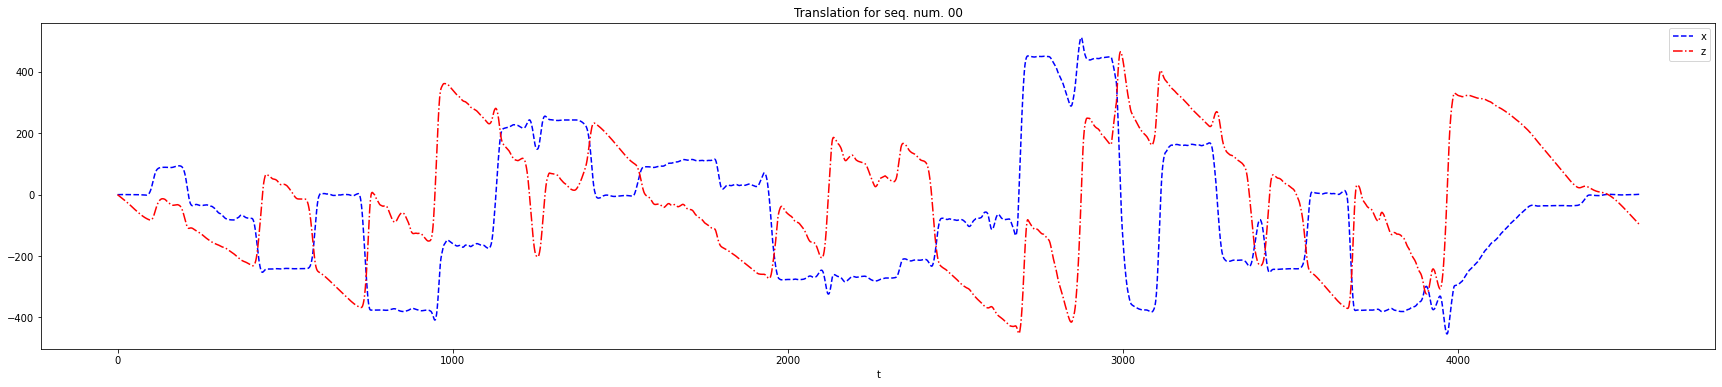

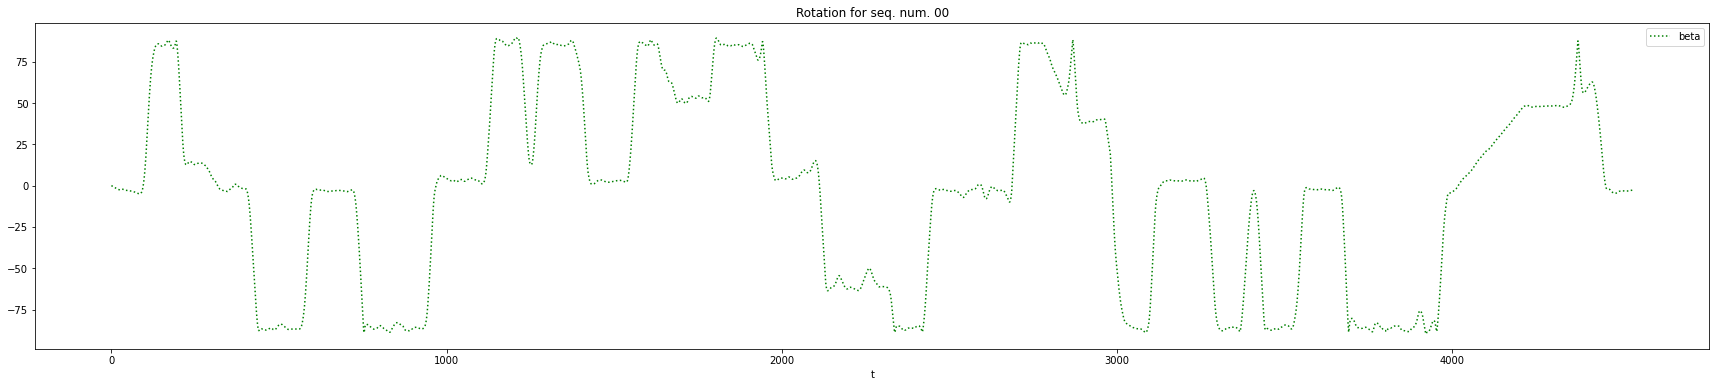

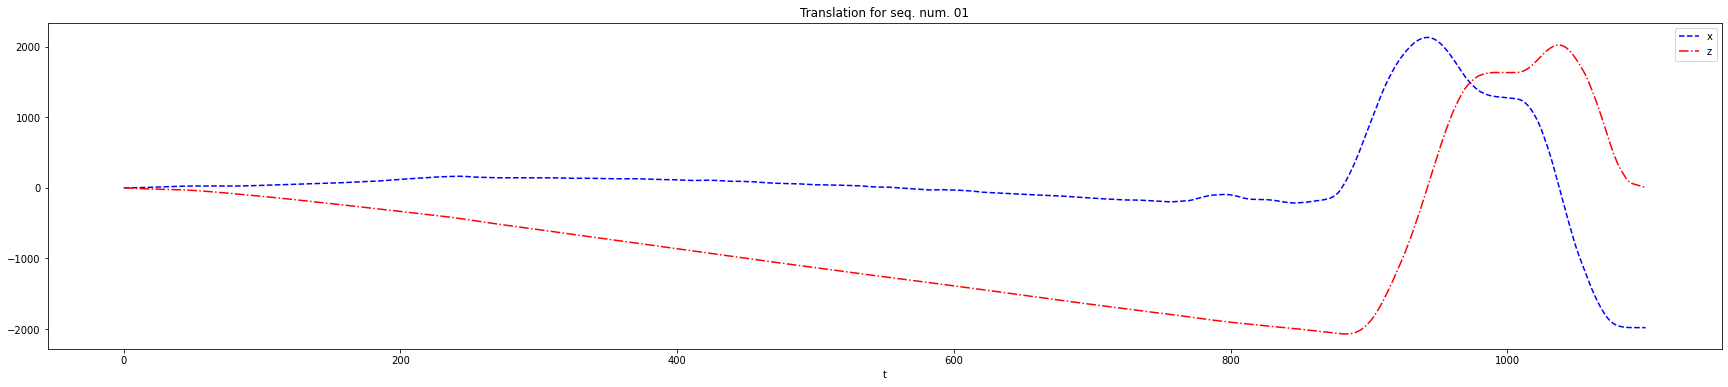

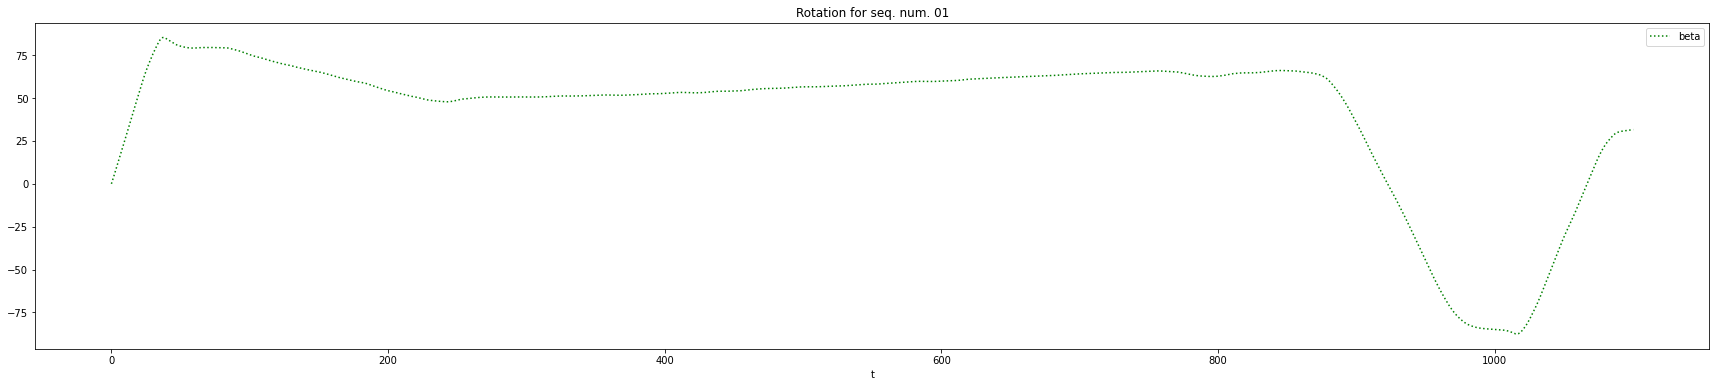

In [13]:
ground_truth_df = pd.DataFrame(df['ground_truth'])
ground_truth_df = pd.DataFrame(df['ground_truth'].to_list(), columns=['x','y','z','alpha','beta','gamma'])

plt.rcParams["figure.figsize"] = (30,6)
for seq_no in ['00','01']:#,'02','03','04','05','06','07','08','09','10']:
  df2 = None
  df2 = ground_truth_df[df['seq_num']== seq_no]
  df2.reset_index(drop=True, inplace=True)
  df2.index = df2.index.map(str)
  df2.index.rename('t',inplace=True)
  df2 = df2.reset_index()
  ax = plt.gca() 
  df2.plot(kind = 'line', x = 't', y = 'x', color = 'blue',linestyle='--',ax = ax)
#   df2.plot(kind = 'line', x = 't', y = 'y', color = 'green',linestyle=':',ax = ax)
  df2.plot(kind = 'line', x = 't', y = 'z', color = 'red',linestyle='-.',ax = ax)
  plt.title('Translation for seq. num. '+seq_no)
  plt.show()
  ax = plt.gca() 
#   df2.plot(kind = 'line', x = 't', y = 'alpha', color = 'blue',linestyle='--',ax = ax)
  df2.plot(kind = 'line', x = 't', y = 'beta', color = 'green',linestyle=':',ax = ax)
#   df2.plot(kind = 'line', x = 't', y = 'gamma', color = 'red',linestyle='-.',ax = ax)
  plt.title('Rotation for seq. num. '+seq_no)
  plt.show()

### Add beta, x, and z in separate columns

In [14]:
gt_df = ground_truth_df.copy()
gt_df.drop(['y', 'alpha', 'gamma'], axis=1, inplace=True)
df['beta'] = gt_df['beta']
df['x'] = gt_df['x']
df['z'] = gt_df['z']
df


,seq_num,ground_truth,bird_eye_view,height,img360,intensity,range,beta,x,z
0,00,"[-5.551115000732093e-17, -3.330669001057406e-1...",/kaggle/working/dataset/sequences/00/bird_eye_...,/kaggle/working/dataset/sequences/00/height_im...,/kaggle/working/dataset/sequences/00/img360/00...,/kaggle/working/dataset/sequences/00/intensity...,/kaggle/working/dataset/sequences/00/range_img...,-0.000000,-5.551115e-17,4.440892e-16
1,00,"[0.045113447450264826, 0.027431373395956728, -...",/kaggle/working/dataset/sequences/00/bird_eye_...,/kaggle/working/dataset/sequences/00/height_im...,/kaggle/working/dataset/sequences/00/img360/00...,/kaggle/working/dataset/sequences/00/intensity...,/kaggle/working/dataset/sequences/00/range_img...,-0.118392,4.511345e-02,-8.588215e-01
2,00,"[0.08659615738057902, 0.05288997897173165, -1....",/kaggle/working/dataset/sequences/00/bird_eye_...,/kaggle/working/dataset/sequences/00/height_im...,/kaggle/working/dataset/sequences/00/img360/00...,/kaggle/working/dataset/sequences/00/intensity...,/kaggle/working/dataset/sequences/00/range_img...,-0.236570,8.659616e-02,-1.716774e+00
3,00,"[0.12455777890801757, 0.07643581057741401, -2....",/kaggle/working/dataset/sequences/00/bird_eye_...,/kaggle/working/dataset/sequences/00/height_im...,/kaggle/working/dataset/sequences/00/img360/00...,/kaggle/working/dataset/sequences/00/intensity...,/kaggle/working/dataset/sequences/00/range_img...,-0.354841,1.245578e-01,-2.576066e+00
4,00,"[0.15890632423944687, 0.09800444791778, -3.434...",/kaggle/working/dataset/sequences/00/bird_eye_...,/kaggle/working/dataset/sequences/00/height_im...,/kaggle/working/dataset/sequences/00/img360/00...,/kaggle/working/dataset/sequences/00/intensity...,/kaggle/working/dataset/sequences/00/range_img...,-0.472913,1.589063e-01,-3.434568e+00
...,...,...,...,...,...,...,...,...,...,...
23196,10,"[419.3550190730212, 30.002111257996823, 348.00...",/kaggle/working/dataset/sequences/10/bird_eye_...,/kaggle/working/dataset/sequences/10/height_im...,/kaggle/working/dataset/sequences/10/img360/00...,/kaggle/working/dataset/sequences/10/intensity...,/kaggle/working/dataset/sequences/10/range_img...,-40.897382,4.193550e+02,3.480050e+02
23197,10,"[419.6231124404058, 29.83882285137777, 347.608...",/kaggle/working/dataset/sequences/10/bird_eye_...,/kaggle/working/dataset/sequences/10/height_im...,/kaggle/working/dataset/sequences/10/img360/00...,/kaggle/working/dataset/sequences/10/intensity...,/kaggle/working/dataset/sequences/10/range_img...,-40.854092,4.196231e+02,3.476086e+02
23198,10,"[419.79577060824266, 29.487491011346364, 347.3...",/kaggle/working/dataset/sequences/10/bird_eye_...,/kaggle/working/dataset/sequences/10/height_im...,/kaggle/working/dataset/sequences/10/img360/00...,/kaggle/working/dataset/sequences/10/intensity...,/kaggle/working/dataset/sequences/10/range_img...,-40.825660,4.197958e+02,3.473488e+02
23199,10,"[419.8943055035746, 29.316638746480443, 347.17...",/kaggle/working/dataset/sequences/10/bird_eye_...,/kaggle/working/dataset/sequences/10/height_im...,/kaggle/working/dataset/sequences/10/img360/00...,/kaggle/working/dataset/sequences/10/intensity...,/kaggle/working/dataset/sequences/10/range_img...,-40.811543,4.198943e+02,3.471717e+02


### plot the history of the training function

In [15]:

#to plot the history of the training function
def read_and_polt_history_file(filename):
    plt.rcParams["figure.figsize"] = (6,6)
    with open(filename) as f:
        data = f.read()
    d = ast.literal_eval(data)
    print("Data type before reconstruction : ", type(d))
    df = pd.DataFrame.from_dict(d)
    df.index = df.index.map(str)
    df.index.rename('Epoch',inplace=True)
    df = df.reset_index() 
    ax = plt.gca() 
    df.plot(kind = 'line', x = 'Epoch', y = 'loss_train', color = 'green',ax = ax)
    df.plot(kind = 'line', x = 'Epoch', y = 'loss_val', color = 'blue',linestyle='-.',ax = ax)
    plt.title('Loss')
    plt.show()
    ax = plt.gca() 
    df.plot(kind = 'line', x = 'Epoch', y = 'train_acc_trans', color = 'green',ax = ax)
    df.plot(kind = 'line', x = 'Epoch', y = 'val_acc_trans', color = 'blue',linestyle='-.',ax = ax)
    plt.title('Loss')
    plt.show()
    ax = plt.gca() 
    df.plot(kind = 'line', x = 'Epoch', y = 'train_acc_rot', color = 'green',ax = ax)
    df.plot(kind = 'line', x = 'Epoch', y = 'val_acc_rot', color = 'blue',linestyle='-.',ax = ax)
    plt.title('Loss')
    plt.show()
    

    return df

## Dataset Class

In [16]:
class KittiDataset(Dataset):
    def __init__(
        self, df: pd.core.frame.DataFrame, seq_nums: list,
         transforms: list = None, bin_size: int = 21
    ):
        super().__init__()

        if transforms is None:
            transforms =  tv.transforms.ToTensor()
        self.transforms = transforms

        intensity_list = []
        range_list = []
        height_list = []

        for seq_num in seq_nums:
            # intensity_list.append(df[df['seq_num'].isin([seq_num])]['intensity'].tolist())
            range_list.append(df[df['seq_num'].isin([seq_num])]['range'].tolist())
            # height_list.append(df[df['seq_num'].isin([seq_num])]['height'].tolist())

        # self.intensity_list = [(intensity[i], intensity[i + 1]) for intensity in intensity_list for i in range(len(intensity) - 1)]


        self.range_list = [(rng[i], rng[i+1]) for rng in range_list for i in range(len(rng) - 1)]
        # self.height_list = [(height[i], height[i+1]) for height in height_list for i in range(len(height) - 1)]
        
        transes = []
        rot = []

        for seq_num in seq_nums:
            dx = np.diff(df[df['seq_num'].isin([seq_num])].iloc[:]['x'])
            dz = np.diff(df[df['seq_num'].isin([seq_num])].iloc[:]['z'])
            transes.append(np.sqrt(dx ** 2 + dz ** 2))

            rot.append(np.diff(df[df['seq_num'].isin([seq_num])].iloc[:]['beta']))

        self.trans = np.hstack(transes)
        self.rot = np.hstack(rot).flatten()
        
        self.trans_bins = np.linspace(self.trans.min(), self.trans.max(), bin_size)
        self.trans_labels = torch.tensor(np.digitize(self.trans, self.trans_bins)).long() -1

        self.rot_bins = np.linspace(self.rot.min(), self.rot.max(), bin_size)
        self.rot_labels = torch.tensor(np.digitize(self.rot, self.rot_bins)).long() -1

    def __getitem__(self, index):

        # intensity1, intensity2 = self.intensity_list[index]
        range1, range2 = self.range_list[index]
        # height1, height2 = self.height_list[index]

        # ch1 = self.transforms(Image.open(intensity1))
        ch2 = self.transforms(Image.open(range1))
        # ch3 = self.transforms(Image.open(height1))
        
        # ch4 = self.transforms(Image.open(intensity2))
        ch5 = self.transforms(Image.open(range2))
        # ch6 = self.transforms(Image.open(height2))

        images = torch.stack([ ch2, ch5], axis=0)
        # images = torch.cat([ ch2, ch5], dim=0)
        # images = torch.cat([ch1, ch2, ch3, ch4, ch5, ch6], dim=0)
        trans_label = self.trans_labels[index]
        rot_label = self.rot_labels[index]

        return  images, trans_label, rot_label

    def __len__(self):
        return len(self.rot_labels)
    

In [17]:
ds = KittiDataset(df, transforms=None, bin_size=21, seq_nums=['00','02','07','08','10'])

In [18]:
ds[0][0]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

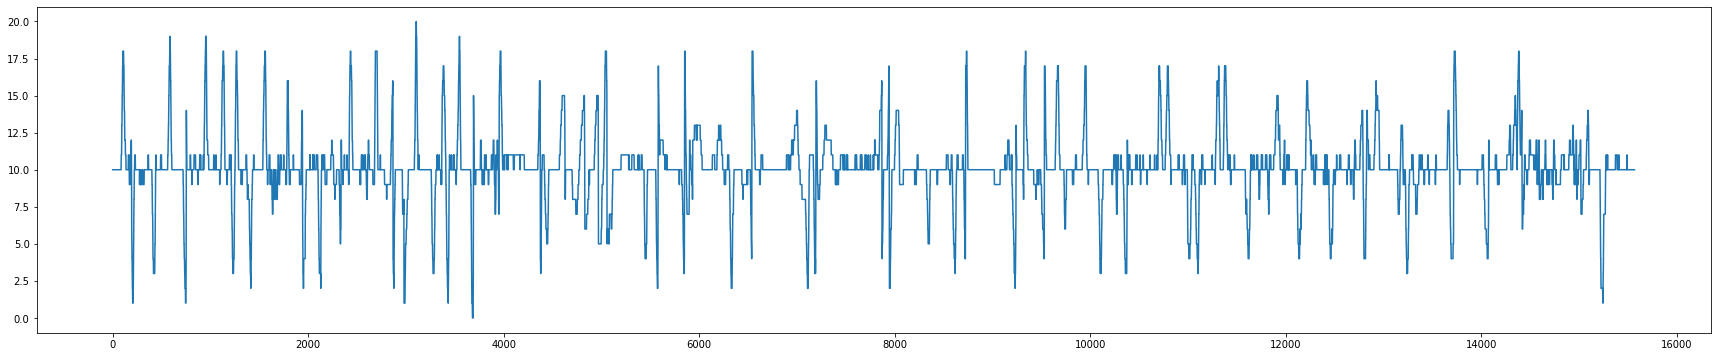

In [19]:
plt.plot(ds.rot_labels)

## Model Class & Functions

In [20]:
class OdometryEstimator(nn.Module):
    def __init__(
        self, img_size: tuple = None,channel_size:int=None, batchNorm: bool = True,
        dropout: list = None, out_features: int = 21, seq_len: int = 2
    ):
        super().__init__()

        if img_size is None:
            img_size = (65, 1025)

        if channel_size is None:
            channel_size = 1

        if dropout is None:
            dropout = [0.2] * 9

        self.batchNorm = batchNorm
        self.img_size = img_size
        self.channel_size = channel_size
        self.seq_len = seq_len

        self.conv1 = nn.Sequential(
            nn.Conv2d(self.channel_size, 32, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(), # inplace=True),
            nn.AvgPool2d(2),
            nn.Dropout(dropout[0]) #, inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(), # inplace=True),
            nn.AvgPool2d(3),
            nn.Dropout(dropout[0]) # ,inplace=True)
        )

        self.rnn_trans = nn.LSTM(
            input_size=self.encoding_size(), hidden_size=128, num_layers=3,
            dropout=0.1, batch_first=True
        )

        self.rnn_rot = nn.LSTM(
            input_size=self.encoding_size(), hidden_size=128, num_layers=3,
            dropout=0.1, batch_first=True
        )
        
        self.fc_network_rot = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=128, out_features=64
            ),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout[0]), #, inplace=True),
            nn.Linear(in_features=64, out_features=out_features),
            nn.Softmax(dim=-1)
        )

        self.fc_network_trans = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=128, out_features=64
            ),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout[0]), #, inplace=True),
            nn.Linear(in_features=64, out_features=out_features),
            nn.Softmax(dim=-1)
        )

    def encoding_size(self):
        tmp = torch.zeros(1, self.channel_size, *self.img_size)

        self.eval()
        with torch.no_grad():
            out = self.encode_image(tmp)
        self.train()

        return out.numel()

    def encode_image(self, x):
        out = self.conv2(self.conv1(x))

        return out

    def forward(self, x):
        # x shape: (batch_size, sql_len=2, channel=1, height, width)

        batch_size = x.size(0)
        # print(f'-----{x.size()}')
        x = torch.cat(( x[:, :-1], x[:, 1:]), dim=2)
        seq_len = x.size(1)
        # print(f'---{x.size()}')
        
        x = x.view(batch_size * seq_len, x.size(2), x.size(3), x.size(4))
        # print(f'--v  -{x.size()}')
        encoding = self.encode_image(x)
        # print(f'--e-{encoding.size()}')

        encoding = encoding.view(batch_size, seq_len, -1)
        
        rnn_out_trans, _ = self.rnn_trans(encoding)
        # print("Here rnn trans")
        rnn_out_rot, _ = self.rnn_rot(encoding)
        # print("rot trans")
        trans_out = self.fc_network_trans(rnn_out_trans)
        # print("fc trans")
        rot_out = self.fc_network_rot(rnn_out_rot)

        return trans_out, rot_out



## Training Function

In [21]:
def train(
    model: nn.Module, epochs: int, train_loader: DataLoader, val_loader: DataLoader,
    loss_fn, optimizer,save_path: str
):
    best_val_loss = 10000
    history = {"loss_train": [], "loss_val": [],"train_acc_trans": [], "val_acc_trans": [],"train_acc_rot": [], "val_acc_rot": []}
    for epoch in range(epochs):
        loss_list = []
        trans_acc_list = []
        rot_acc_list = []
        correct_trans = 0
        correct_rot = 0
        to_print = ""
        model.train()
        for x, y_trans, y_rot in train_loader:
            x, y_trans, y_rot = x.to(device), y_trans.to(device), y_rot.to(device)
            optimizer.zero_grad()
            y_hat_trans, y_hat_rot = model(x)
            loss_trans = loss_fn(y_hat_trans, y_trans)
            loss_rot = loss_fn(y_hat_rot, y_rot)
            loss = loss_trans + loss_rot
            loss.backward()
            optimizer.step()


            correct_trans += torch.count_nonzero(torch.argmax(y_hat_trans,axis=-1) == y_trans).item()
            correct_rot += torch.count_nonzero(torch.argmax(y_hat_rot,axis=-1) == y_rot).item()
            loss_list.append(loss.item())
            
        trans_acc_list.append(correct_trans / len(train_loader.dataset))
        rot_acc_list.append(correct_rot / len(train_loader.dataset))
        
        train_trans_acc = np.mean(trans_acc_list)
        train_rot_acc = np.mean(rot_acc_list)
        train_loss = np.mean(loss_list)
        history['train_acc_trans'].append(train_trans_acc)
        history['train_acc_rot'].append(train_rot_acc)
        history["loss_train"].append(train_loss)
        to_print += f"Train (Loss: {train_loss: .3f}, trans.acc.: {train_trans_acc: .3f}, rot.acc.: {train_rot_acc: .3f}) |   "

        model.eval()
        loss_list = []
        trans_acc_list = []
        rot_acc_list = []
        correct_trans = 0
        correct_rot = 0
        with torch.no_grad():
            for x, y_trans, y_rot in val_loader:
                x, y_trans, y_rot = x.to(device), y_trans.to(device), y_rot.to(device)
                y_hat_trans, y_hat_rot = model(x)
                loss_trans = loss_fn(y_hat_trans, y_trans)
                loss_rot = loss_fn(y_hat_rot, y_rot)
                correct_trans += torch.count_nonzero(torch.argmax(y_hat_trans,axis=-1) == y_trans).item()
                correct_rot += torch.count_nonzero(torch.argmax(y_hat_rot,axis=-1) == y_rot).item()
                loss = loss_trans + loss_rot

                loss_list.append(loss.item())
            trans_acc_list.append(correct_trans / len(train_loader.dataset))
            rot_acc_list.append(correct_rot / len(train_loader.dataset))
            

            val_trans_acc = np.mean(trans_acc_list)
            val_rot_acc = np.mean(rot_acc_list)
            val_loss = np.mean(loss_list)
            history['val_acc_trans'].append(val_trans_acc)
            history['val_acc_rot'].append(val_rot_acc)
            history["loss_val"].append(val_loss)
            to_print += f"Val. (Loss: {val_loss: .3f}, trans.acc.: {val_trans_acc: .3f}, rot.acc.: {val_rot_acc: .3f})"
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(
                {
                    "model_state": model.state_dict(),
                    "history": history
                },
                save_path+'/best.pt'
            )
        torch.save(
            {
                "model_state": model.state_dict(),
                "history": history
            },
            save_path+'/last.pt'
        )
        print(f'{epoch +1}\t',to_print)

    return history

## ...

In [22]:
stack_len = 2
overlap = 1
channel_size = 1
bins_number = 50
batch_size = 100
img_size = (65, 1025)
save_path="/kaggle/working/"

In [23]:
torch.cuda.empty_cache()

In [24]:
img_transform = tv.transforms.Compose([
    # tv.transforms.Resize(img_size),
     tv.transforms.ToTensor()
])

In [25]:
%%time
train_ds = KittiDataset(df, seq_nums=['00','02','07','08','10'], transforms=img_transform,bin_size=bins_number)
val_ds = KittiDataset(df, seq_nums=['01','04','05'], transforms=img_transform,bin_size=bins_number)
test_ds = KittiDataset(df, seq_nums=['03','06','09'], transforms=img_transform,bin_size=bins_number)
01','04','05

CPU times: user 145 ms, sys: 7.13 ms, total: 152 ms
Wall time: 159 ms


In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [27]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)

In [28]:
model = OdometryEstimator(img_size, batchNorm=True, dropout=[0.05] * 9, out_features=bins_number, channel_size=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [29]:
# from google.colab import drive
# drive.mount('/content/drive')

## ...

In [30]:
history = train(model, 100, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer, save_path)

1	 Train (Loss:  7.608, trans.acc.:  0.286, rot.acc.:  0.194) |   Val. (Loss:  7.556, trans.acc.:  0.078, rot.acc.:  0.029)
2	 Train (Loss:  7.284, trans.acc.:  0.403, rot.acc.:  0.289) |   Val. (Loss:  7.381, trans.acc.:  0.114, rot.acc.:  0.036)
3	 Train (Loss:  7.197, trans.acc.:  0.429, rot.acc.:  0.294) |   Val. (Loss:  7.312, trans.acc.:  0.133, rot.acc.:  0.036)
4	 Train (Loss:  7.150, trans.acc.:  0.457, rot.acc.:  0.301) |   Val. (Loss:  7.237, trans.acc.:  0.141, rot.acc.:  0.037)
5	 Train (Loss:  7.129, trans.acc.:  0.464, rot.acc.:  0.303) |   Val. (Loss:  7.253, trans.acc.:  0.138, rot.acc.:  0.032)
6	 Train (Loss:  7.120, trans.acc.:  0.473, rot.acc.:  0.305) |   Val. (Loss:  7.110, trans.acc.:  0.170, rot.acc.:  0.038)
7	 Train (Loss:  7.112, trans.acc.:  0.473, rot.acc.:  0.307) |   Val. (Loss:  7.232, trans.acc.:  0.143, rot.acc.:  0.033)
8	 Train (Loss:  7.098, trans.acc.:  0.479, rot.acc.:  0.314) |   Val. (Loss:  7.220, trans.acc.:  0.151, rot.acc.:  0.027)
9	 Train

In [32]:
with open('history.txt', 'w') as convert_file:
     convert_file.write(json.dumps(history))
# history

Data type before reconstruction :  <class 'dict'>


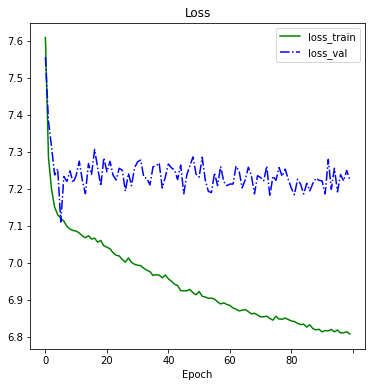

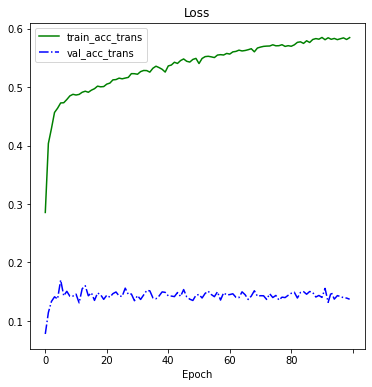

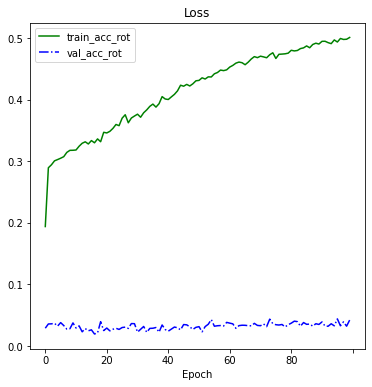

In [33]:
history_df = read_and_polt_history_file(history.txt')

In [ ]:
!pip install torchsummary 

In [ ]:
from torchsummary import summary

md = OdometryEstimator(img_size, batchNorm=True, dropout=[0.05] * 9, out_features=bins_number, channel_size=2)
summary(md, (3, 224, 224))